## MSc Business Analytics & Management - Thesis - Data analysis

#### Authored by Benjamin Aston on 24/02/2025

### Randomisation of test cases

#### Packages

In [314]:
#Import packages
import pandas as pd
import numpy as np
import sqlite3
from skimpy import skim
from ydata_profiling import ProfileReport
import sweetviz as sv
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import dowhy
from dowhy import CausalModel
import networkx as nx
from econml.grf import CausalForest
from scipy.stats import qmc
from scipy.spatial.distance import pdist, squareform
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import entropy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import os
from scipy.spatial.distance import pdist
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.utils import resample
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import entropy

### Data ingestion

### Phase 1 - Initiate LDS latin hypercube selection -  No executions times known

In [316]:
# === CONFIGURATION === #
num_initial_tests = 6  # Number of initial LHS test cases - works well with 35
num_bo_tests = 1  # how many changes are made per iteration
tolerance_threshold = 5000  # BO stopping threshold for entropy reduction 
execution_results_file = r"C:\Users\benja\Documents\MSC BAM\THESIS\Gitrepo\CHATGPT - STARTERS PACKAGE\New synthetic data\Synthetic_Data_with_Execution_Time.csv"  

# === DEFINE CATEGORICAL VALUES - 6 by 6 by 6 search space === #
db_memory_values = [250, 750, 1250, 1750, 2250, 2500]
mas_workers_values = [10, 22, 34, 46, 58, 70]
parallel_jobs_values = [10, 20, 30, 40, 50, 60]

# === STEP 1: LHS SAMPLING PHASE (WITHOUT EXECUTION TIME) === #
sampler = qmc.LatinHypercube(d=3, seed=42)
lhs_samples = sampler.random(num_initial_tests)

df_lhs_initial = pd.DataFrame(columns=["DB_Memory", "MAS_Workers", "Parallel_Jobs"])
df_lhs_initial["DB_Memory"] = [db_memory_values[int(i * len(db_memory_values)) % len(db_memory_values)] for i in lhs_samples[:, 0]]
df_lhs_initial["MAS_Workers"] = [mas_workers_values[int(i * len(mas_workers_values)) % len(mas_workers_values)] for i in lhs_samples[:, 1]]
df_lhs_initial["Parallel_Jobs"] = [parallel_jobs_values[int(i * len(parallel_jobs_values)) % len(parallel_jobs_values)] for i in lhs_samples[:, 2]]

#Merge id back on
configs = pd.read_csv(r"C:\Users\benja\Documents\MSC BAM\THESIS\Gitrepo\CHATGPT - STARTERS PACKAGE\New synthetic data\All_configurations.csv")
df_lhs_initial = df_lhs_initial.merge(configs, on=["DB_Memory", "MAS_Workers", "Parallel_Jobs"], how="inner")

# === SAVE LHS TEST CASES FOR EXECUTION === #
lhs_output_path = r"C:\Users\benja\Documents\MSC BAM\THESIS\Gitrepo\CHATGPT - STARTERS PACKAGE\New synthetic data\LHS_Selected_Test_Cases.xlsx"
print(df_lhs_initial)

# Compute pairwise Euclidean distances between LHS-selected test cases
lhs_points = df_lhs_initial[["DB_Memory", "MAS_Workers", "Parallel_Jobs"]].values
pairwise_distances = pdist(lhs_points, metric='euclidean')

# Compute coverage score (how many unique values per parameter were chosen)
coverage_score = {
    "DB_Memory": len(df_lhs_initial["DB_Memory"].unique()) / len(db_memory_values),
    "MAS_Workers": len(df_lhs_initial["MAS_Workers"].unique()) / len(mas_workers_values),
    "Parallel_Jobs": len(df_lhs_initial["Parallel_Jobs"].unique()) / len(parallel_jobs_values)
}

# Compute discrepancy metric (variation from uniformity in the LHS selection)
lhs_discrepancy = np.var(pairwise_distances)  # Higher variance means uneven coverage

# Store LHS selection metrics
lhs_metrics = {
    "Mean Pairwise Distance": np.mean(pairwise_distances),
    "Coverage Score": coverage_score,
    "Discrepancy Metric": lhs_discrepancy
}

# Display LHS selection metrics
print(lhs_metrics)

df_lhs_initial.to_excel(lhs_output_path, index=False)
print(f"✅ LHS test cases saved! Please execute and update results in: {lhs_output_path}")

# === WAIT FOR EXECUTION RESULTS === #
print("⏳ Waiting for execution results to be available...")
while not os.path.exists(execution_results_file):
    pass  # Keep checking until execution results are available

   DB_Memory  MAS_Workers  Parallel_Jobs Configuration
0       1750           34             60    Config_126
1       1250           70             30    Config_105
2        750           10             20     Config_38
3       2500           46             40    Config_202
4       2250           58             50    Config_173
5        250           22             10      Config_7
{'Mean Pairwise Distance': 1084.2742047163265, 'Coverage Score': {'DB_Memory': 1.0, 'MAS_Workers': 1.0, 'Parallel_Jobs': 1.0}, 'Discrepancy Metric': 346890.78232011094}
✅ LHS test cases saved! Please execute and update results in: C:\Users\benja\Documents\MSC BAM\THESIS\Gitrepo\CHATGPT - STARTERS PACKAGE\New synthetic data\LHS_Selected_Test_Cases.xlsx
⏳ Waiting for execution results to be available...


In [326]:
# === STEP 2: LOAD EXECUTION RESULTS === #
df_execution_results = pd.read_csv(execution_results_file)

# Merge execution results back into LHS test cases
df_lhs_completed = df_lhs_initial.merge(df_execution_results, on=["DB_Memory", "MAS_Workers", "Parallel_Jobs"], how="inner")
del df_lhs_completed['Configuration_y']
df_lhs_completed.rename(columns={"Configuration_x": "Configuration"}, inplace=True)
df_lhs_completed

,DB_Memory,MAS_Workers,Parallel_Jobs,Configuration,Execution_Time
0,1750,34,60,Config_126,55.809421
1,1250,70,30,Config_105,22.035825
2,750,10,20,Config_38,46.989528
3,2500,46,40,Config_202,33.842221
4,2250,58,50,Config_173,33.533512
5,250,22,10,Config_7,38.635195


   DB_Memory  MAS_Workers  Parallel_Jobs Configuration  Execution_Time  \
0       1750           34             60    Config_126       55.809421   
1       1250           70             30    Config_105       22.035825   
2        750           10             20     Config_38       46.989528   
3       2500           46             40    Config_202       33.842221   
4       2250           58             50    Config_173       33.533512   
5        250           22             10      Config_7       38.635195   

  Sampling_Method  
0             LHS  
1             LHS  
2             LHS  
3             LHS  
4             LHS  
5             LHS  
✅ Stopping Bayesian Optimization. Entropy has sufficiently decayed.


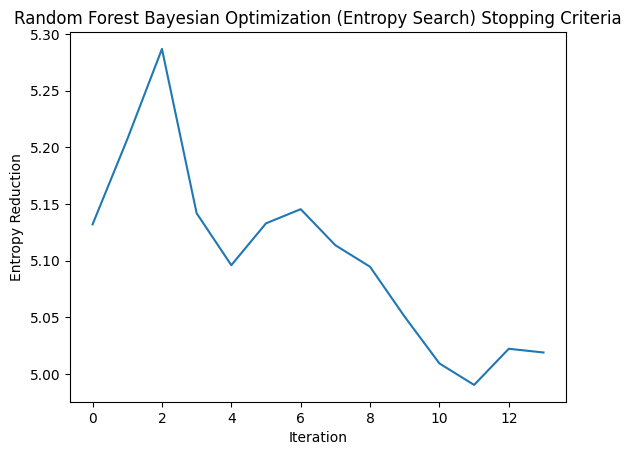

✅ Bayesian Optimization Process Completed!


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\benja\\Documents\\MSC BAM\\THESIS\\Gitrepo\\CHATGPT - STARTERS PACKAGE\\New synthetic data\\Synthetic_simulated_cases_selected_all.xlsx'

In [332]:
# === CONFIGURATION === #
tolerance_threshold = 0.009  # Stopping threshold for entropy reduction - can be tuned
num_trees = 100  # Number of trees in Random Forest
exploration_weights = 0.1

# Load Phase 1 selected test cases (LHS)
lhs_selected_file = r"C:\Users\benja\Documents\MSC BAM\THESIS\Gitrepo\CHATGPT - STARTERS PACKAGE\New synthetic data\LHS_Selected_Test_Cases.xlsx"
df_lhs_selected = pd.read_excel(lhs_selected_file)

# Load execution times for all configurations
execution_results_file = r"C:\Users\benja\Documents\MSC BAM\THESIS\Gitrepo\CHATGPT - STARTERS PACKAGE\New synthetic data\Synthetic_Data_with_Execution_Time.csv"
df_execution_results = pd.read_csv(execution_results_file)

# Merge LHS test cases with execution times (PHASE 1 DATA)
df_lhs_completed = df_lhs_selected.merge(
    df_execution_results, on=["DB_Memory", "MAS_Workers", "Parallel_Jobs"], how="inner"
)
df_lhs_completed["Sampling_Method"] = "LHS"  # Mark these as LHS-selected

# Remove duplicate 'Configuration' columns after merging
df_lhs_completed = df_lhs_completed.rename(columns={"Configuration_x": "Configuration"}).drop(columns=["Configuration_y"], errors="ignore")

# Ensure 'Configuration' column is properly formatted
df_lhs_completed["Configuration"] = df_lhs_completed["Configuration"].astype(str).str.strip()

# Load all possible test cases
all_configs_file = r"C:\Users\benja\Documents\MSC BAM\THESIS\Gitrepo\CHATGPT - STARTERS PACKAGE\New synthetic data\All_configurations.csv"
df_all_configs = pd.read_csv(all_configs_file)

# Prepare a DataFrame for BO-selected test cases
bo_selected_cases = []
entropy_values = []

print(df_lhs_completed)

# Load Bayesian Optimization Results (Iteratively selected test cases)
X_train = df_lhs_completed[["DB_Memory", "MAS_Workers", "Parallel_Jobs"]].values
y_train = df_lhs_completed["Execution_Time"].values

# Initialize Random Forest Model
rf = RandomForestRegressor(n_estimators=num_trees, random_state=42)
rf.fit(X_train, y_train)

# Initialize the used_configs set with LHS-selected configurations
used_configs = set(df_lhs_completed["Configuration"].unique())  # Ensure LHS configs are excluded from BO

# Remove used configs from df_all_configs **before the loop**
df_all_configs = df_all_configs[~df_all_configs["Configuration"].isin(used_configs)].copy()

# **Iterative Bayesian Optimization Loop**
while not df_all_configs.empty:  # Keep looping until all configs are used
    # Predict mean and standard deviation using trained Random Forest
    mu = rf.predict(df_all_configs[["DB_Memory", "MAS_Workers", "Parallel_Jobs"]].values)
    sigma = np.std([tree.predict(df_all_configs[["DB_Memory", "MAS_Workers", "Parallel_Jobs"]].values) 
                    for tree in rf.estimators_], axis=0)  # Estimate uncertainty

    # **Entropy-Based Acquisition Function**
    exploration_weight = exploration_weights  # Tune this for more exploration
    entropy_gain = sigma + exploration_weight * np.random.rand(len(sigma))

    # Select next test case with highest entropy reduction
    next_index = np.argmax(entropy_gain)
    next_test_case = df_all_configs.iloc[next_index]

    # Remove this test case from df_all_configs permanently
    df_all_configs = df_all_configs.drop(df_all_configs.index[next_index])

    # Get actual execution time from dataset
    real_execution_time = df_execution_results.loc[
        (df_execution_results["DB_Memory"] == next_test_case["DB_Memory"]) &
        (df_execution_results["MAS_Workers"] == next_test_case["MAS_Workers"]) &
        (df_execution_results["Parallel_Jobs"] == next_test_case["Parallel_Jobs"]),
        "Execution_Time"
    ].values

    if len(real_execution_time) == 0:
        continue  # Skip if execution time is missing
    else:
        real_execution_time = real_execution_time[0]

    # Store the selected test case with method label
    bo_selected_cases.append({
        "Configuration": next_test_case["Configuration"],
        "MAS_Workers": next_test_case["MAS_Workers"],
        "DB_Memory": next_test_case["DB_Memory"],
        "Parallel_Jobs": next_test_case["Parallel_Jobs"],
        "Sampling_Method": "BO",
        "Execution_Time": real_execution_time,
        "Entropy_Value": entropy_gain[next_index]  # ✅ Only store the selected entropy value
    })

    # Update training data
    new_test_case = np.array([[next_test_case["DB_Memory"], next_test_case["MAS_Workers"], next_test_case["Parallel_Jobs"]]])
    X_train = np.vstack((X_train, new_test_case))
    y_train = np.append(y_train, real_execution_time)
    rf.fit(X_train, y_train)

    # Check entropy reduction for stopping condition
    entropy_values.append(entropy(np.abs(mu - np.mean(mu))))
    if len(entropy_values) > 1 and np.abs(entropy_values[-1] - entropy_values[-2]) < tolerance_threshold:
        print("✅ Stopping Bayesian Optimization. Entropy has sufficiently decayed.")
        break

# Convert BO-selected cases to DataFrame
df_bo_completed = pd.DataFrame(bo_selected_cases)

# Combine LHS and BO results into a single DataFrame
df_lhs_completed = df_lhs_completed.rename(columns={"Configuration_x": "Configuration"}).drop(columns=["Configuration_y"], errors='ignore')
df_final_selected_cases = pd.concat([df_lhs_completed, df_bo_completed], ignore_index=True)

# Plot entropy reduction over iterations
plt.plot(entropy_values)
plt.xlabel("Iteration")
plt.ylabel("Entropy Reduction")
plt.title("Random Forest Bayesian Optimization (Entropy Search) Stopping Criteria")
plt.show()

print("✅ Bayesian Optimization Process Completed!")
df_final_selected_cases.to_excel(r"C:\Users\benja\Documents\MSC BAM\THESIS\Gitrepo\CHATGPT - STARTERS PACKAGE\New synthetic data\Synthetic_simulated_cases_selected_all.xlsx")

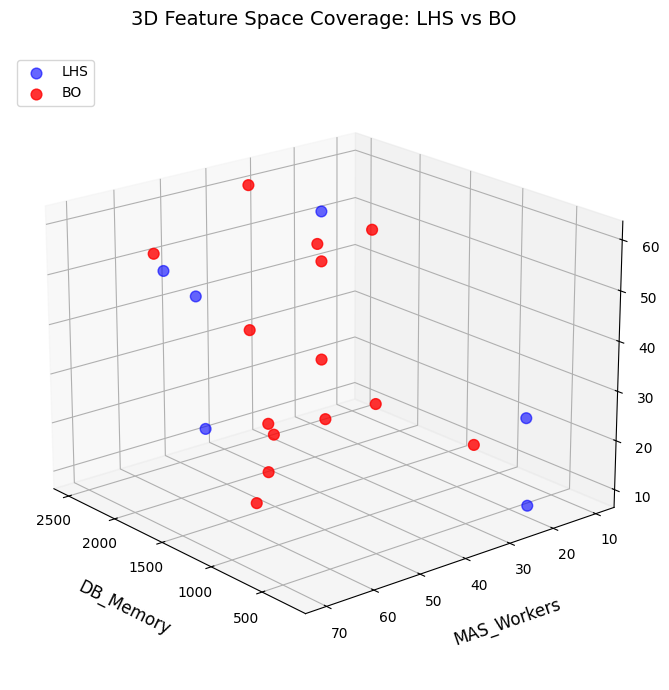

In [334]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create a larger figure to avoid layout cropping
fig = plt.figure(figsize=(10, 7))  
ax = fig.add_subplot(111, projection='3d')

# Plot LHS
lhs_data = df_final_selected_cases[df_final_selected_cases["Sampling_Method"] == "LHS"]
ax.scatter(lhs_data["DB_Memory"], lhs_data["MAS_Workers"], lhs_data["Parallel_Jobs"], 
           c='blue', label="LHS", alpha=0.6, s=60)

# Plot BO
bo_data = df_final_selected_cases[df_final_selected_cases["Sampling_Method"] == "BO"]
ax.scatter(bo_data["DB_Memory"], bo_data["MAS_Workers"], bo_data["Parallel_Jobs"], 
           c='red', label="BO", alpha=0.8, s=60)

# ✅ Ensure axis labels are clearly visible
ax.set_xlabel("DB_Memory", fontsize=12, labelpad=15)
ax.set_ylabel("MAS_Workers", fontsize=12, labelpad=15)
ax.set_zlabel("Parallel_Jobs", fontsize=12, labelpad=15)

# ✅ Adjust axis tick labels
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='z', labelsize=10)

# ✅ Improve the 3D viewing angle (adjust as needed)
ax.view_init(elev=20, azim=140)  # This prevents axis clipping

# ✅ Add a title
ax.set_title("3D Feature Space Coverage: LHS vs BO", fontsize=14, pad=20)

# ✅ Ensure all elements fit properly
plt.tight_layout()

# ✅ Add legend
ax.legend(fontsize=10, loc="upper left")

# Show plot
plt.show()


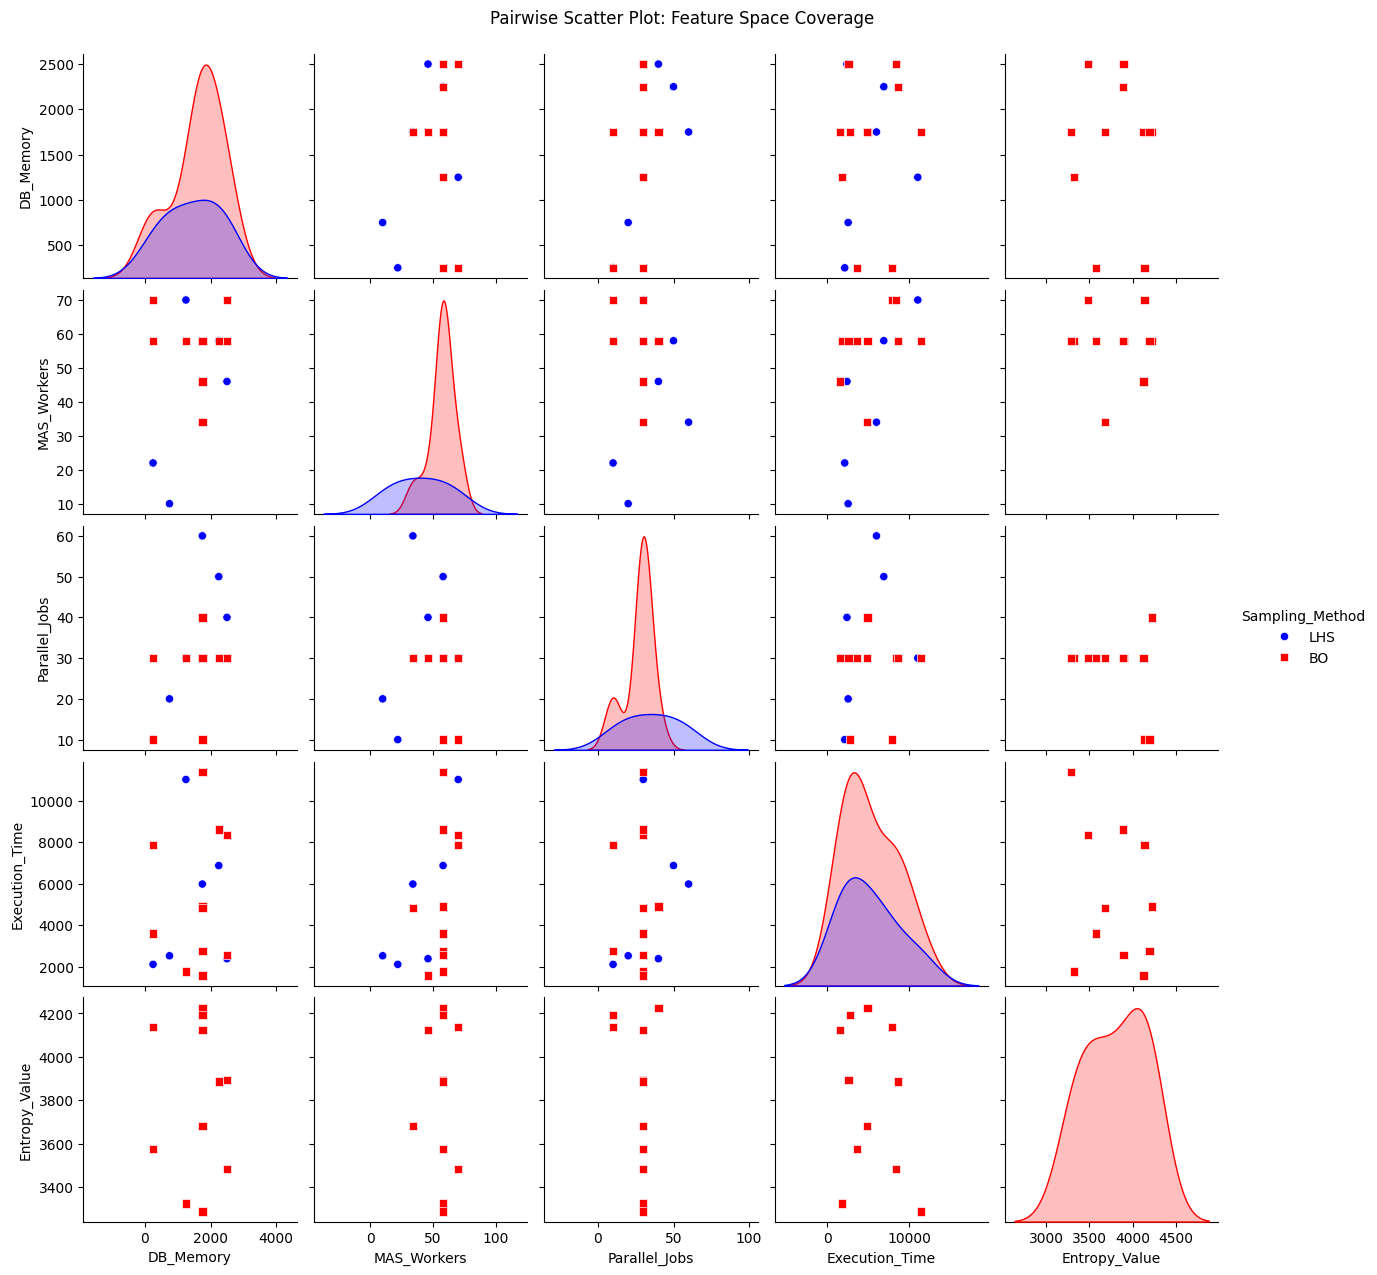

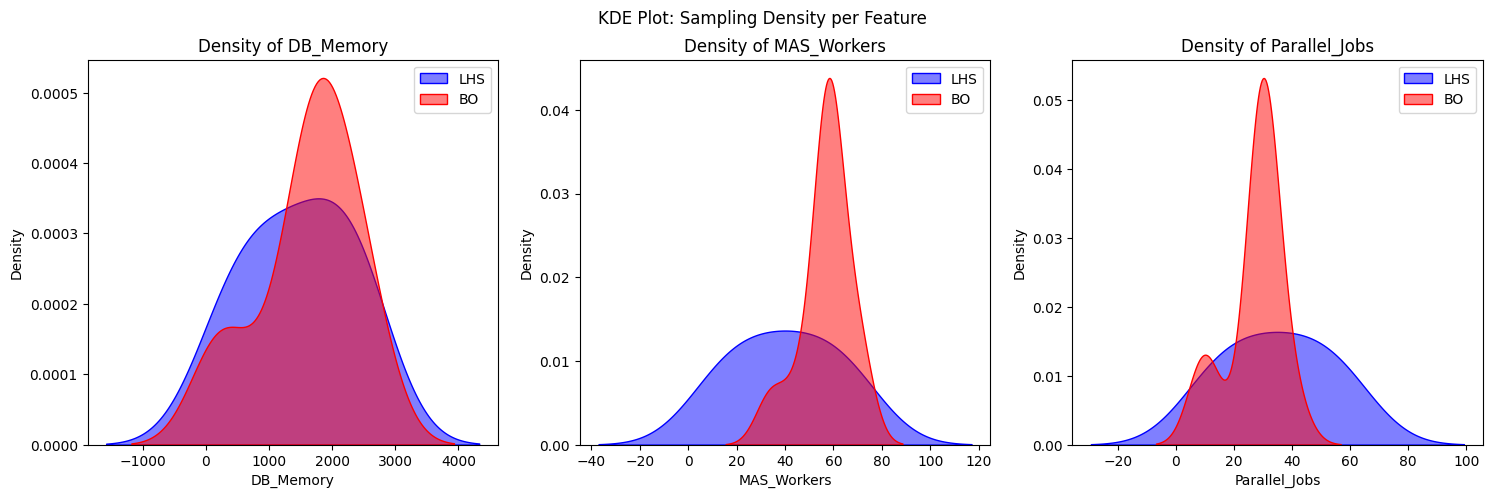

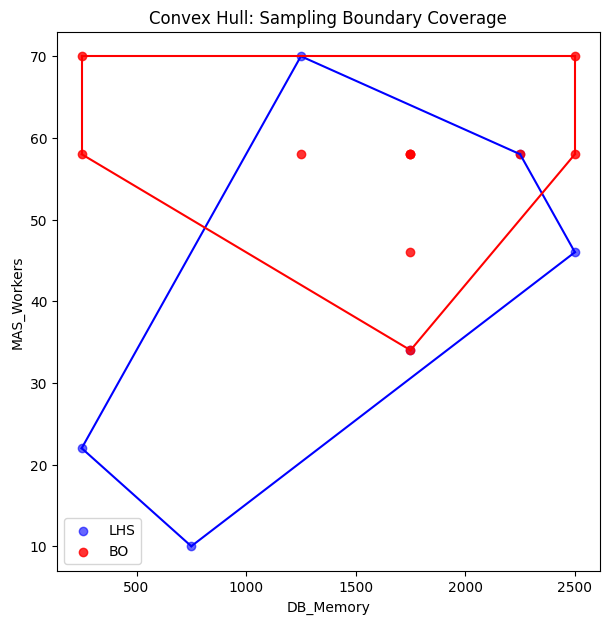

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

# Load dataset (assuming df_final_selected_cases is already loaded)
df = df_final_selected_cases

# Define colors for LHS and BO
colors = {"LHS": "blue", "BO": "red"}

# 1️⃣ **Pairwise Scatter Plot Matrix** (Feature Space Projection)
sns.pairplot(df, hue="Sampling_Method", palette=colors, markers=["o", "s"])
plt.suptitle("Pairwise Scatter Plot: Feature Space Coverage", y=1.02)
plt.show()

# 2️⃣ **Kernel Density Estimation (KDE) Plot** (Density of Sampled Points)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

features = ["DB_Memory", "MAS_Workers", "Parallel_Jobs"]

for i, feature in enumerate(features):
    sns.kdeplot(df[df["Sampling_Method"] == "LHS"][feature], label="LHS", color="blue", fill=True, alpha=0.5, ax=axes[i])
    sns.kdeplot(df[df["Sampling_Method"] == "BO"][feature], label="BO", color="red", fill=True, alpha=0.5, ax=axes[i])
    axes[i].set_title(f"Density of {feature}")
    axes[i].legend()

plt.suptitle("KDE Plot: Sampling Density per Feature")
plt.show()

# 3️⃣ **Convex Hull (Boundary Coverage) Visualization**
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

# Extract 2D projection (DB_Memory vs MAS_Workers)
lhs_points = df[df["Sampling_Method"] == "LHS"][["DB_Memory", "MAS_Workers"]].values
bo_points = df[df["Sampling_Method"] == "BO"][["DB_Memory", "MAS_Workers"]].values

# Plot original points
ax.scatter(lhs_points[:, 0], lhs_points[:, 1], c="blue", label="LHS", alpha=0.6)
ax.scatter(bo_points[:, 0], bo_points[:, 1], c="red", label="BO", alpha=0.8)

# Compute and plot convex hull for LHS
if len(lhs_points) > 2:
    hull = ConvexHull(lhs_points)
    for simplex in hull.simplices:
        ax.plot(lhs_points[simplex, 0], lhs_points[simplex, 1], "b-")

# Compute and plot convex hull for BO
if len(bo_points) > 2:
    hull = ConvexHull(bo_points)
    for simplex in hull.simplices:
        ax.plot(bo_points[simplex, 0], bo_points[simplex, 1], "r-")

ax.set_xlabel("DB_Memory")
ax.set_ylabel("MAS_Workers")
ax.set_title("Convex Hull: Sampling Boundary Coverage")
ax.legend()

plt.show()


### Data cleaning of collected data

#### Descriptives

In [258]:
#Dummy setting of variables
Synthetic_data = pd.get_dummies(Synthetic_data, columns=["DB_Memory"], drop_first=True)

NameError: name 'Synthetic_data' is not defined

In [ ]:
#Summarise with skimpy
skim(Synthetic_data)

#Create report
profile = ProfileReport(Synthetic_data, title="Synthetic_data Profiling Report", explorative=True)

# Save the report as an HTML file
profile.to_file("Synthetic_data_profile_report.html")

#Use sweetviz for more summary reports
report = sv.analyze(Synthetic_data)
report.show_html("Synthetic_data_sweetviz_report.html")


#### Cleaning leading and na's

In [ ]:
# Remove leading and trailing whitespaces from values
Synthetic_data.columns = Synthetic_data.columns.str.strip()

#Count NAs in columns
for col in Synthetic_data.columns:
    na_count = Synthetic_data[col].isna().sum()
    print(f"Missing values in {col}: {na_count}")

#No missings, if there are any in the future, they need to be tackled


#### Outliers and scaling

In [1]:
#Outlier analysis using Z scores
for col in Numeric_cols:
    z_scores = np.abs(stats.zscore(Synthetic_data[col]))
    outliers = Synthetic_data[z_scores > 3]
    print(outliers)

#Category defined
Synthetic_data['DB_Memory'] = Synthetic_data['DB_Memory'].astype('category')

#Scale variables
#Cols to not scale
No_scale = ["Configuration","Execution_time"]

# Scale it into the same df
columns_to_scale = [col for col in Synthetic_data.columns if col not in No_scale]

# Initialize the scaler
scaler = StandardScaler()
Synthetic_data[columns_to_scale] = scaler.fit_transform(Synthetic_data[columns_to_scale])

NameError: name 'Numeric_cols' is not defined

#### Causal analysis set up

#### DoWhy analysis

In [ ]:
common_causes = ["DB_Memory", "MAS_Workers","P"] + \
    [col for col in Synthetic_data.columns if "System_Memory" in col or "Database_Memory" in col]

model = CausalModel(
    data=Synthetic_data,
    treatment="treatment",
    outcome="Execution_Time",
    common_causes=common_causes
)

#### Show DAG based on set up

In [ ]:
# Create a Directed Graph
G = nx.DiGraph()

# Define bidirectional relationships (single thick blue arrows with two heads)
edges_bidirectional = [
    ('PARALLEL JOBS', 'DATABASE STORAGE'),
    ('MAS WORKERS', 'DATABASE STORAGE'),
    ('MAS WORKERS', 'PARALLEL JOBS')
]

# Define unidirectional relationships (single thin black arrows)
edges_unidirectional = [
    ('PARALLEL JOBS', 'EXECUTION TIME'),
    ('DATABASE STORAGE', 'EXECUTION TIME'),
    ('MAS WORKERS', 'EXECUTION TIME'),
    ('JSON CHARACTERISTICS', 'EXECUTION TIME'),
    ('JSON CHARACTERISTICS', 'MAS WORKERS'),
    ('JSON CHARACTERISTICS', 'PARALLEL JOBS'),
    ('JSON CHARACTERISTICS', 'DATABASE STORAGE')
]

# Add edges to the graph
G.add_edges_from(edges_unidirectional)
G.add_edges_from(edges_bidirectional)

# Generate a position layout using 'kamada_kaway_layout' for better separation
pos = nx.kamada_kawai_layout(G)

# Assign colors: Red for 'Execution Time', White for 'JSON CHARACTERISTICS', Green for others
node_colors = {
    "EXECUTION TIME": "red",
    "JSON CHARACTERISTICS": "white"
}
default_color = "green"
node_color_list = [node_colors.get(node, default_color) for node in G.nodes()]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_color_list, edgecolors="black", node_size=2000, ax=ax)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold", ax=ax)

# Draw bidirectional edges as a single thick blue line with two arrowheads
for a, b in edges_bidirectional:
    nx.draw_networkx_edges(G, pos, edgelist=[(a, b)], edge_color="blue", width=3, ax=ax, arrows=True, arrowstyle='<->')

# Draw unidirectional edges as thin black arrows
nx.draw_networkx_edges(G, pos, edgelist=edges_unidirectional, edge_color="black", width=1, ax=ax, arrows=True)

# Set title
plt.title("Causal DAG with Bidirectional (Blue) and Unidirectional Relationships (Black)", fontsize=12)

# Show the plot
plt.show()


In [ ]:
# Visualize the assumed causal graph
model.view_model()

### M3E2 Neural Network or similar

#### Test train split